# AoU FHIR & OMOP Analysis
Information about Sync for Science and OMOP patients, and comparing the data of each.

First, define the locations of the data we wish to analyze and compare, and import the necessary modules.

In [1]:
import os
import pandas as pd
import omop_analyze
import fhir_analyze
import aou_analysis

current_directory = os.getcwd()
omop_directory = "\\omop\\20190823"
fhir_directory = "\\fhir\\Participant"

## 1: FHIR Summary
pull in fhir data, let's find some basic data on the number of patients and number of entries retrived

In [2]:
fhir_patients = fhir_analyze.traverse_directory(current_directory+fhir_directory)

got 83 s4s participants


### 1 a: Histogram showing counts for each data category, across the population

In [3]:
fhir_category_counts_df = aou_analysis.fhir_plot_category_counts(fhir_patients)
display(fhir_category_counts_df)

### 1 b: raw counts of histogram buckets

In [ ]:
export_df(fhir_category_counts_df, 'export/fhir_category_counts.csv')

### 1 c: Most common code systems for each data category

In [4]:
aou_analysis.configure_tables()
fhir_systems = aou_analysis.code_system_counts(fhir_patients)
for category, counter in fhir_systems.items():
    df = pd.DataFrame(counter.most_common())
    df.index.name = category
    display(df)

""
PATIENT_DEMOGRAPHICS


,0,1
SMOKING_STATUS,,
0,http://loinc.org,591
1,http://snomed.info/sct,427


,0,1
PROBLEMS,,
0,http://snomed.info/sct,3875
1,http://hl7.org/fhir/sid/icd-9-cm,1537
2,urn:oid:2.16.840.1.113883.6.90,1154
3,http://hl7.org/fhir/sid/icd-9-cm/diagnosis,990
4,http://hl7.org/fhir/sid/icd-10-cm,810


,0,1
MEDICATION_ORDER,,
0,http://www.nlm.nih.gov/research/umls/rxnorm,5031
1,None,36
2,http://hl7.org/fhir/sid/ndc,5


,0,1
MEDICATION_STATEMENT,,
0,http://www.nlm.nih.gov/research/umls/rxnorm,7737
1,https://apis.followmyhealth.com/fhir/id/translation,23


,0,1
ALLERGY_INTOLERANCE,,
0,http://www.nlm.nih.gov/research/umls/rxnorm,431
1,http://fdasis.nlm.nih.gov,202
2,http://hl7.org/fhir/ndfrt,162
3,http://snomed.info/sct,134
4,http://hl7.org/fhir/sid/ndc,25
5,None,25


,0,1
LAB,,
0,http://loinc.org,26149


,0,1
VITAL,,
0,http://loinc.org,57167
1,http://snomed.info/sct,1597


,0,1
PROCEDURE,,
0,http://www.ama-assn.org/go/cpt,268
1,urn:oid:1.2.840.114350.1.13.202.2.7.2.696580,122
2,http://snomed.info/sct,119
3,urn:oid:1.2.840.114350.1.13.362.2.7.2.696580,36
4,urn:oid:1.2.840.114350.1.13.324.2.7.2.696580,28
5,urn:oid:2.16.840.1.113883.6.14,17
6,urn:oid:1.2.840.114350.1.13.71.2.7.2.696580,8
7,None,6


,0,1
IMMUNIZATION,,
0,http://hl7.org/fhir/sid/cvx,1773
1,http://hl7.org/fhir/sid/ndc,272
2,http://www.ama-assn.org/go/cpt,110


,0,1
DOCUMENT,,
0,http://loinc.org,531


### 1 d: Most common standardized codes for each data category

In [5]:
fhir_codings = aou_analysis.coding_counts(fhir_patients)
for category, table in fhir_codings.items():
    df = pd.DataFrame(table)
    df.index.name = category
    display(df)

""
PATIENT_DEMOGRAPHICS


,code,count,display,system
SMOKING_STATUS,,,,
0,88031-0,237,None,http://loinc.org
1,72166-2,234,Tobacco smoking status NHIS,http://loinc.org
2,714151003,161,Environmental tobacco smoke exposure (observable entity),http://snomed.info/sct
3,8663-7,109,None,http://loinc.org
4,363905002,54,Details of alcohol drinking behavior (observable entity),http://snomed.info/sct
5,224130005,24,Household composition (observable entity),http://snomed.info/sct
6,48766-0,20,None,http://loinc.org
7,266918002,17,Tobacco smoking consumption (observable entity),http://snomed.info/sct
8,73985-4,11,None,http://loinc.org


,code,count,display,system
PROBLEMS,,,,
0,73211009,239,None,http://snomed.info/sct
1,305058001,188,None,http://snomed.info/sct
2,77386006,122,Patient currently pregnant (finding),http://snomed.info/sct
3,29857009,106,None,http://snomed.info/sct
4,55822004,90,Hyperlipidemia (disorder),http://snomed.info/sct
5,195967001,77,None,http://snomed.info/sct
6,300.00,77,"Anxiety state, unspecified",http://hl7.org/fhir/sid/icd-9-cm
7,228315001,72,Binge drinker (finding),http://snomed.info/sct
8,25064002,66,None,http://snomed.info/sct


,code,count,display,system
MEDICATION_ORDER,,,,
0,308416,680,Aspir 81 oral delayed release tablet,http://www.nlm.nih.gov/research/umls/rxnorm
1,243670,195,aspirin 81 mg oral tablet,http://www.nlm.nih.gov/research/umls/rxnorm
2,3498,140,Diphenhydramine,http://www.nlm.nih.gov/research/umls/rxnorm
3,161,135,None,http://www.nlm.nih.gov/research/umls/rxnorm
4,8640,135,None,http://www.nlm.nih.gov/research/umls/rxnorm
5,23950,130,EMLA,http://www.nlm.nih.gov/research/umls/rxnorm
6,5224,120,heparin,http://www.nlm.nih.gov/research/umls/rxnorm
7,259966,105,methylPREDNISolone 4 mg oral tablet,http://www.nlm.nih.gov/research/umls/rxnorm
8,318272,85,"aspirin 81 mg oral tablet, chewable",http://www.nlm.nih.gov/research/umls/rxnorm


,code,count,display,system
MEDICATION_STATEMENT,,,,
0,3498,336,Diphenhydramine,http://www.nlm.nih.gov/research/umls/rxnorm
1,8640,325,None,http://www.nlm.nih.gov/research/umls/rxnorm
2,161,324,None,http://www.nlm.nih.gov/research/umls/rxnorm
3,23950,312,EMLA,http://www.nlm.nih.gov/research/umls/rxnorm
4,5224,288,heparin,http://www.nlm.nih.gov/research/umls/rxnorm
5,313782,194,acetaminophen 325 mg tablet,http://www.nlm.nih.gov/research/umls/rxnorm
6,202433,180,Tylenol,http://www.nlm.nih.gov/research/umls/rxnorm
7,203457,168,Benadryl,http://www.nlm.nih.gov/research/umls/rxnorm
8,10379,108,Testosterone,http://www.nlm.nih.gov/research/umls/rxnorm


,code,count,display,system
ALLERGY_INTOLERANCE,,,,
0,2670,59,None,http://www.nlm.nih.gov/research/umls/rxnorm
1,716186003,47,No known allergy,http://snomed.info/sct
2,QE1QX6B99R,40,None,http://fdasis.nlm.nih.gov
3,N0000007394,26,LATEX,http://hl7.org/fhir/ndfrt
4,256349002,25,Peanut - dietary (substance),http://snomed.info/sct
5,111088007,25,Latex (substance),http://snomed.info/sct
6,256259004,25,Pollen (substance),http://snomed.info/sct
7,None,25,FLUZONE PEDIATRIC,http://hl7.org/fhir/sid/ndc
8,N0000008034,22,SULFA (SULFONAMIDE ANTIBIOTICS),http://hl7.org/fhir/ndfrt


,code,count,display,system
LAB,,,,
0,2160-0,579,Creatinine [Mass/volume] in Serum or Plasma,http://loinc.org
1,2345-7,553,Glucose [Mass/volume] in Serum or Plasma,http://loinc.org
2,17861-6,542,Calcium [Mass/volume] in Serum or Plasma,http://loinc.org
3,3094-0,537,Urea nitrogen [Mass/volume] in Serum or Plasma,http://loinc.org
4,2823-3,533,Potassium [Moles/volume] in Serum or Plasma,http://loinc.org
5,2075-0,519,Chloride [Moles/volume] in Serum or Plasma,http://loinc.org
6,2028-9,499,"Carbon dioxide, total [Moles/volume] in Serum or Plasma",http://loinc.org
7,6690-2,494,Leukocytes [#/volume] in Blood by Automated count,http://loinc.org
8,789-8,489,Erythrocytes [#/volume] in Blood by Automated count,http://loinc.org


,code,count,display,system
VITAL,,,,
0,8716-3,28222,Vital signs,http://loinc.org
1,39156-5,713,None,http://loinc.org
2,225908003,356,Pain score (observable entity),http://snomed.info/sct
3,86198006,160,Influenza vaccination (procedure),http://snomed.info/sct
4,19928-1,125,None,http://loinc.org
5,8327-9,113,None,http://loinc.org
6,41904-4,100,None,http://loinc.org
7,8478-0,93,None,http://loinc.org
8,3151-8,90,None,http://loinc.org


,code,count,display,system
PROCEDURE,,,,
0,86580,52,PR TB INTRADERMAL TEST,http://www.ama-assn.org/go/cpt
1,10224242,41,GENERAL PROCEDURE,urn:oid:1.2.840.114350.1.13.202.2.7.2.696580
2,90412006,25,"Colonoscope, device (physical object)",http://snomed.info/sct
3,69210,19,PR REMOVE IMPACTED EAR WAX,http://www.ama-assn.org/go/cpt
4,G0121,17,PR COLON CA SCRN NOT HI RSK IND,urn:oid:2.16.840.1.113883.6.14
5,93351,15,"PR ECHO HEART XTHORACIC, STRESS/REST, W CONTIN ECG",http://www.ama-assn.org/go/cpt
6,93010,15,"ELECTROCARDIOGRAM, ROUTINE W/AT LEAST 12 LEADS",http://www.ama-assn.org/go/cpt
7,128454,13,SPIROMETRY - NURSING,urn:oid:1.2.840.114350.1.13.324.2.7.2.696580
8,92133,12,PR COMPUTERIZED OPHTHALMIC IMAGING OPTIC NERVE,http://www.ama-assn.org/go/cpt


,code,count,display,system
IMMUNIZATION,,,,
0,140,172,None,http://hl7.org/fhir/sid/cvx
1,115,136,None,http://hl7.org/fhir/sid/cvx
2,88,126,INFLUENZA,http://hl7.org/fhir/sid/cvx
3,98,104,TUBERCULIN PPD TEST,http://hl7.org/fhir/sid/cvx
4,150,100,None,http://hl7.org/fhir/sid/cvx
5,139,57,Td(adult) unspecified formulation,http://hl7.org/fhir/sid/cvx
6,110,50,None,http://hl7.org/fhir/sid/cvx
7,08,49,None,http://hl7.org/fhir/sid/cvx
8,10,47,POLIO,http://hl7.org/fhir/sid/cvx


,code,count,display,system
DOCUMENT,,,,
0,11506-3,389,Subsequent evaluation note,http://loinc.org
1,34133-9,142,Summarization of Episode Note,http://loinc.org


### 1 e: Count of valid vs invalid codes per data category

### 1 f: Tree of FHIR JSON data structure and counts

In [6]:
rootNodes = {}
for person, documents in fhir_patients.items():
    for document, data in documents.items():
        if document not in rootNodes:
            rootNodes[document] = aou_analysis.Node()    
        for entry in data:
            aou_analysis.traverse(entry, rootNodes[document])
rootNodes

{'PATIENT_DEMOGRAPHICS': <dict children: {
    resourceType: <str total: 83 values: 
       Patient: 83>
    birthDate: <str total: 83>
    active: <bool total: 83 values: 
       True: 83>
    gender: <str total: 83>
    deceasedBoolean: <bool total: 73 values: 
       False: 72
       True: 1>
    id: <str total: 83>
    careProvider: <list top values: [('1', 74), ('2', 2)] children: {
       dict: <dict children: {
          display: <str total: 78>
          reference: <str total: 78>
       }>
    }>
    name: <list top values: [('1', 74), ('5', 6), ('4', 2), ('3', 1)] children: {
       dict: <dict children: {
          use: <str total: 105>
          text: <str total: 110>
          family: <list top values: [('1', 115)] children: {
             str: <str total: 115>
          }>
          given: <list top values: [('2', 60), ('1', 55)] children: {
             str: <str total: 175>
          }>
          period: <dict children: {
             start: <str total: 16>
            

# 2: OMOP Summary

number of patients and records retrieved from OMOP CSVs

In [7]:
omop_patients, csvs = omop_analyze.parse_omop(path=current_directory+omop_directory)

line without patient: OrderedDict([('', '0'), ('SNOMED', '11474'), ('RxNorm', '97'), ('LOINC', '15001'), ('PPI', '12567'), ('None', '3384'), ('N', '3036'), ('CPT4', '569'), ('ICD9Proc', '49')])
Got 74 omop participants


### 2 a:Histogram showing counts for each OMOP data type, across the population. 

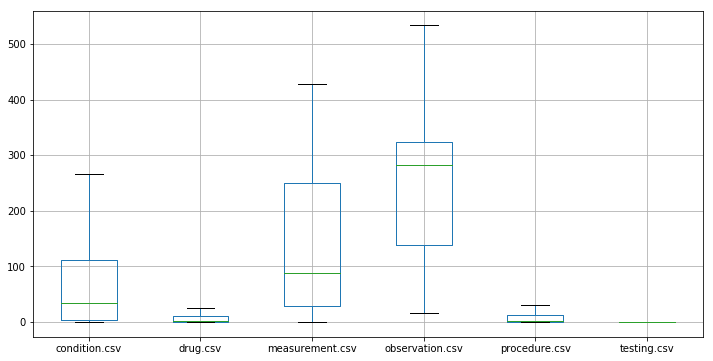

In [11]:
omop_category_counts_df = aou_analysis.omop_plot_category_counts(omop_patients, csvs)
display(omop_category_counts_df)

### 2 b: Count of standardized code *systems* for each OMOP data type.

In [ ]:
system_counts = aou_analysis.omop_system_counts(omop_patients)
pd.DataFrame(system_counts, index=[0])
aou_analysis.export_df(pd.DataFrame(system_counts, index=[0]), 'export/omop_system_counts.csv')

### 2 c: Top N standardized codes for each data category.

In [ ]:
coding_counts = aou_analysis.omop_coding_counts(omop_patients)
for name, counter in coding_counts.items():
    print(name)
    display(pd.DataFrame(counter.most_common()))
    aou_analysis.export_df(pd.DataFrame(counter.most_common()), 'export/omop_'+name.split('.')[0]+'coding_counts.csv')

### 2 e: For each OMOP column, how often was a value present vs absent? 

### 2 f: For each OMOP column representing a status flag, what is the distribution of values? 

# 3: Comparison of OMOP and FHIR data
